In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(1337)
random.seed(1337)

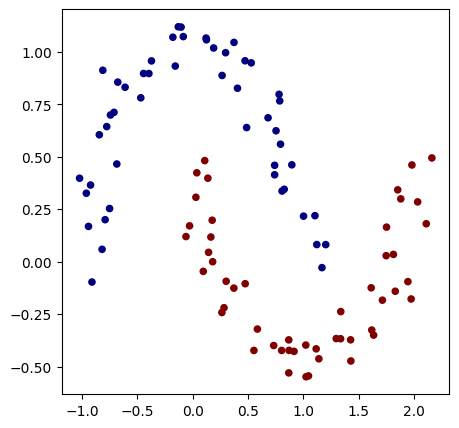

In [3]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [4]:
import torch
import torch.nn as nn

In [5]:
X = torch.Tensor(X)
y = torch.Tensor(y).view(-1, 1)

X.shape, y.shape

(torch.Size([100, 2]), torch.Size([100, 1]))

In [6]:
model = nn.Sequential(
    nn.Linear(2, 16),
    nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
)

## ReLU
https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

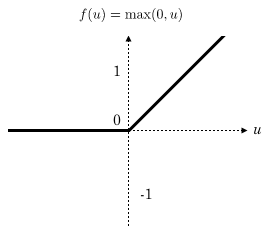

In [15]:
model

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
)

In [7]:
logits = model(X)

## Hinge Loss
https://en.wikipedia.org/wiki/Hinge_loss

In [8]:
def max_margin_loss(output, target):
    temp = (1 + -target*output).clip(min=0)
    data_loss = torch.sum(temp) * (1.0 / len(temp))
    # L2 regularization
    alpha = 1e-4
    reg_loss = 0
    for p in model.parameters():
        p_val = p.detach().numpy()
        reg_loss = np.sum(p_val*p_val)
    reg_loss = alpha * reg_loss
    total_loss = data_loss + reg_loss
    return total_loss

## Stochastic Gradient Decent
https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam

![image.png](SGD.gif)

In [9]:
num_epochs = 100
batch_size = 10
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_fn = max_margin_loss

In [10]:
for n in range(num_epochs):
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    acc, correct = (0, 0)
    with torch.no_grad():
        pred = model(X)
        np_pred = pred.detach().numpy()
        correct = sum([(yi > 0) == (scorei.data > 0) for yi, scorei in zip(y, pred)])
    acc = correct / len(X)
    if n % 10 == 0:
        print(f"step {n} loss {loss.data:>7f}, accuracy {acc*100}%")

step 0 loss 1.040961, accuracy tensor([84.])%
step 10 loss 0.273858, accuracy tensor([88.])%
step 20 loss 0.096729, accuracy tensor([97.])%
step 30 loss 0.006270, accuracy tensor([100.])%
step 40 loss 0.000015, accuracy tensor([100.])%
step 50 loss 0.000017, accuracy tensor([100.])%
step 60 loss 0.000735, accuracy tensor([100.])%
step 70 loss 0.002230, accuracy tensor([100.])%
step 80 loss 0.000018, accuracy tensor([100.])%
step 90 loss 0.000019, accuracy tensor([100.])%


In [11]:
def predict(model, X):
    with torch.no_grad():
        logits = model(X).numpy()
        logits[logits > 0] = 1
        logits[logits < 0] = -1
        return logits.astype(int)

In [12]:
y_pred = predict(model, X)

## Visualize the decision boundary

(-1.5486392974853516, 1.9513607025146484)

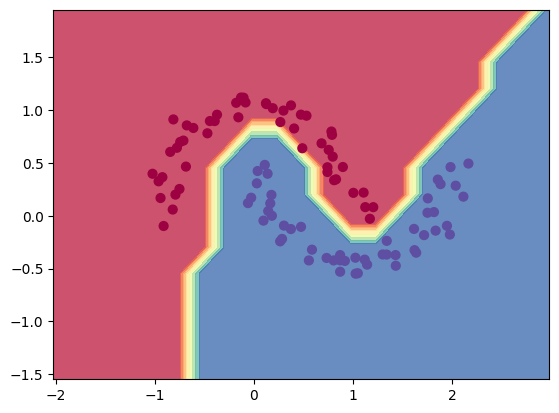

In [13]:
# visualize decision boundary
# based on https://hackernoon.com/how-to-plot-a-decision-boundary-for-machine-learning-algorithms-in-python-3o1n3w07

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]

Z = predict(model, torch.Tensor(Xmesh))

Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

